## VQE and Quantum Graph Neural Networks

In [3]:
import numpy
import math
import random
import numpy as np
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
import networkx as nx
import cirq

In order to begin thinking about the quantum graph neural network, we must prepare some training data. We perform VQE in order to find the ground state of a given Ising model Hamiltonian:

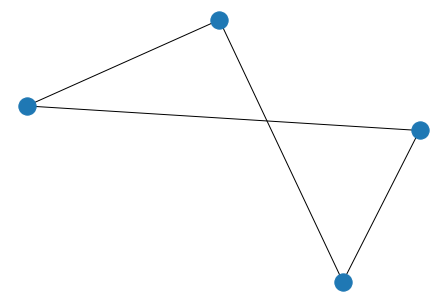

[[3.8, 5.7, 2.1, 8.2], [8.9, 2.8, 3.4, 2.5]]


In [4]:
# Initialize the necessary qubits

qubit_number = 4
data_register = [cirq.GridQubit(0, i) for i in range(0, qubit_number)]
network_register = [cirq.GridQubit(1, i) for i in range(0, qubit_number)]

# Creates the graph structure of the quantum system

ising_graph = nx.Graph()
ising_graph.add_nodes_from(range(0, qubit_number))
ising_graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])

nx.draw(ising_graph)
plt.show() 

# Creates parameters

matrix_params = [[random.randint(10, 100)/10 for i in range(0, 4)] for j in range(0, 2)]
print(matrix_params)

In [17]:
# Defines the rz gate:

def rz(control, target, param):
    yield cirq.CX.on(control, target)
    yield cirq.rz(param).on(target)
    yield cirq.CX.on(control, target)

# Method that initializes qubits in even superposition

def even_superposition(qubits):
    
    for i in qubits:
        yield cirq.H.on(i)

# Method that prepares the QAOA ansatz layers

def qaoa_layer(param1, param2, qubits, ising_graph):
    
    # Applies another layer of coupling gates
    for count, i in enumerate(ising_graph.edges):
        yield rz(qubits[i[0]], qubits[i[1]], 2*param1[count])
    
    # Applies the final layer of RX gates on the qubits
    
    for i in range(0, len(qubits)):
        yield cirq.rx(2*param2[i]).on(qubits[i])
    
# Method that prepares the decoupled layers

def decoupled_layer(param1, param2, qubits):
    
    for i in range(0, len(qubits)):
        yield cirq.ZPowGate(exponent=param1[i]).on(qubits[i])
        yield cirq.XPowGate(exponent=param1[i]).on(qubits[i])

# Method that prepares the VQE circuit that will be used to 

def vqe_circuit(parameters, qubits, ising_graph):
    
    yield decoupled_layer(parameters[0], parameters[1], qubits) 
    yield decoupled_layer(parameters[2], parameters[3], qubits)

test_circuit = cirq.Circuit()
test_circuit.append(vqe_circuit([[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]], data_register, ising_graph))
print(test_circuit)

(0, 0): ───Z───X───Z───X───

(0, 1): ───Z───X───Z───X───

(0, 2): ───Z───X───Z───X───

(0, 3): ───Z───X───Z───X───


In [18]:
# Creates the Hamiltonian that we are attempting to learn

def create_hamiltonian_matrix(n, graph):
    
    # Defines Pauli matrices

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    matrix = np.zeros((2**n, 2**n))
    
    # Creates the interaction component of the Hamiltonian

    for count, i in enumerate(graph.edges):
        m = 1
        for j in range(0, n):
            if (i[0] == j or i[1] == j):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, matrix_params[0][count]*m)
    
    # Creates the "bias" component of the matrix
    
    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, matrix_params[1][i]*m)

    return matrix

print(create_hamiltonian_matrix(qubit_number, ising_graph))

[[ 19.8   2.5   3.4   0.    2.8   0.    0.    0.    8.9   0.    0.    0.
    0.    0.    0.    0. ]
 [  2.5  -8.    0.    3.4   0.    2.8   0.    0.    0.    8.9   0.    0.
    0.    0.    0.    0. ]
 [  3.4   0.   -0.8   2.5   0.    0.    2.8   0.    0.    0.    8.9   0.
    0.    0.    0.    0. ]
 [  0.    3.4   2.5   4.2   0.    0.    0.    2.8   0.    0.    0.    8.9
    0.    0.    0.    0. ]
 [  2.8   0.    0.    0.    8.    2.5   3.4   0.    0.    0.    0.    0.
    8.9   0.    0.    0. ]
 [  0.    2.8   0.    0.    2.5 -19.8   0.    3.4   0.    0.    0.    0.
    0.    8.9   0.    0. ]
 [  0.    0.    2.8   0.    3.4   0.   -4.2   2.5   0.    0.    0.    0.
    0.    0.    8.9   0. ]
 [  0.    0.    0.    2.8   0.    3.4   2.5   0.8   0.    0.    0.    0.
    0.    0.    0.    8.9]
 [  8.9   0.    0.    0.    0.    0.    0.    0.    0.8   2.5   3.4   0.
    2.8   0.    0.    0. ]
 [  0.    8.9   0.    0.    0.    0.    0.    0.    2.5  -4.2   0.    3.4
    0.    2.8   0.    0. 

-25.42676587953767


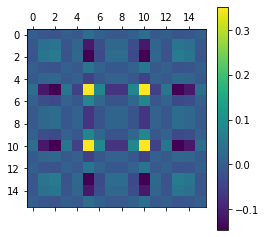

In [19]:
def create_density_matrix(arr):
    
    array = np.array(arr)
    plt.matshow(array)
    plt.colorbar()
    plt.show()

# Finds the eigenvector corresponding to the lowest energy state
    
val, vec = np.linalg.eig(create_hamiltonian_matrix(qubit_number, ising_graph))
m = []

min_ind = list(val).index(min(val))
print(val[min_ind])
for i in range(0, 2**qubit_number):
    m.append(vec[i][min_ind])

'''
def apply(n):
    return float(n*np.conj(n))

func_vec = np.vectorize(apply)
new = func_vec(np.outer(m, m))
'''

create_density_matrix(np.real(np.outer(m, np.conj(m))))

Cost at Step 0= -4.649870412645847
Cost at Step 50= -22.598943958649937
Cost at Step 100= -24.110182237316756
Cost at Step 150= -24.652191783891872
Cost at Step 200= -24.73966678207708
Cost at Step 250= -24.74930239185026
Cost at Step 300= -24.75460138308627
Cost at Step 350= -24.756181786720344
Cost at Step 400= -24.75655354721322
Cost at Step 450= -24.75665807297885
Cost at Step 500= -24.756666367803028
Cost at Step 550= -24.75666977708461
Cost at Step 600= -24.756679731299684
Cost at Step 650= -24.756682162168122
     fun: -24.756682162168122
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 651
  status: 1
 success: True
       x: array([2.30490186, 2.12115186, 2.41149583, 1.44187201, 1.79075897,
       1.32129088, 0.81269368, 1.39644607, 0.88853207, 0.5113275 ,
       0.93205832, 0.04859766, 1.72037567, 0.83255426, 0.32807198,
       1.56377427])


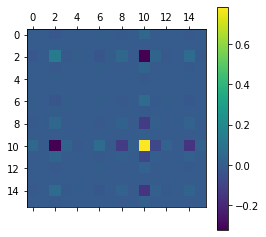

In [20]:
# Creates the VQE method that we will optimize

def create_circuit(parameters, qubits):
    
    # Prepares the circuit
    
    circuit = cirq.Circuit()
    circuit.append(even_superposition(qubits))
    circuit.append(vqe_circuit(parameters, qubits, ising_graph))
    
    # Creates the simulation
    
    simulator = cirq.Simulator()
    results = simulator.simulate(circuit)
    state_vector = results.final_state
    
    return state_vector

# Creates the cost function

iterations = 0

def cost_function(parameters, qubits):
    
    global iterations
    
    hamiltonian = create_hamiltonian_matrix(qubit_number, ising_graph)
    vector = create_circuit(parameters, qubits)
    
    first = np.matmul(hamiltonian, vector)
    cost = np.inner(np.conj(vector), first)
    
    if (iterations%50 == 0):
        print("Cost at Step "+str(iterations)+"= "+str(np.real(cost)))
    
    iterations += 1
    
    return np.real(cost)

# Creates the optimizer for our variational circuit

qubit_register = network_register

def optimizer_cost(params):
    
    parameters = [
        params[0:4], 
        params[4:8],
        params[8:12],
        params[12:16]
    ]
    
    return cost_function(parameters, qubit_register)

# Creates the optimizer

init = [random.randint(0, 20)/10 for i in range(0, 16)]
out = minimize(optimizer_cost, x0=init, method="COBYLA", options={'maxiter':1000, 'tol':1e-10})
g = out['x']
print(out)

# Prepares the optimal state and visualizes it

optimal_params = [
        g[0:4], 
        g[4:8],
        g[8:12],
        g[12:16]
    ]

optimal = create_circuit(optimal_params, qubit_register)
result = np.real(np.outer(optimal, np.conj(optimal)))
create_density_matrix(result)

v = [ 3.21629331,  0.54890376,  2.02976445,  0.7818173 ,  1.3213677 ,
        1.48080682,  1.67054856,  1.44101918,  1.20196752,  0.56441884,
       -0.31570509,  0.15785939,  1.69543663,  0.72541886,  0.02910459,
       -0.52821689]

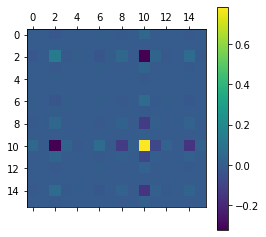

In [25]:
# Attempts to evolve the prepared ground state forward in time, with the time evolution circuit

hbar = 1

def le_state_evolve(depth, time, qubits, ising_graph, params):
    
    yield even_superposition(qubits)
    yield vqe_circuit(params, qubits, ising_graph)
    for i in range(0, depth):
        yield qaoa_layer([time/depth for i in range(0, len(ising_graph.edges))], [time/depth for i in range(0, qubit_number)], qubits, ising_graph)

# Creates the circuit

def create_time_circuit(depth, time, qubits, ising_graph, params):
    
    circuit = cirq.Circuit()
    circuit.append(le_state_evolve(depth, time, qubits, ising_graph, params))
    
    simulator = cirq.Simulator()
    results = simulator.simulate(circuit)
    state_vector = results.final_state
    
    return state_vector

vector = create_time_circuit(800, 0, data_register, ising_graph, optimal_params)
create_density_matrix(np.real(np.outer(vector, np.conj(vector))))

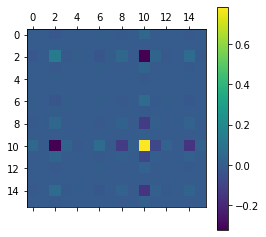

Fidelity: (1.0000003362990781+0j)


In [26]:
# Creates the numrical simulation, to test our time-evolution circuit

def time_evolution_test(time, vec):
    
    new_matrix = scipy.linalg.expm(complex(0,-1)*create_hamiltonian_matrix(qubit_number, ising_graph)*time / hbar)
    return np.matmul(new_matrix, vec)

vec = time_evolution_test(0, optimal)
create_density_matrix(np.real(np.outer(vec, np.conj(vec))))

print("Fidelity: "+str(np.inner(np.conj(vec), vector)*np.inner(np.conj(vector), vec)))

In [578]:
# Creates the initial "guess" graph of interactions, and assigns parameters to each of the edges

initial_graph = nx.complete_graph(qubit_number)

# Creates the SWAP test between two registers of qubits

def swap_test(control, index1, index2):
    
    yield cirq.H.on(control)
    for i in range(0, len(index1)):
        yield cirq.CSWAP(control, index1[i], index2[i])
    yield cirq.H.on(control)

# Creates the QGRNN ansatz

def qgrnn_ansatz(initial_graph, parameters, opt_params, depth, qubits, time):
    
    yield even_superposition(qubits)
    yield vqe_circuit(opt_params, qubits, ising_graph)
    for i in range(0, depth):
        yield qaoa_layer([i*time/depth for i in parameters[0]], [i*time/depth for i in parameters[1]], qubits, initial_graph)

def find_infidelity_time(depth, time, index1, index2, control, params, opt_params, ising_graph, initial_graph):
    
    circuit = cirq.Circuit()
    circuit.append(le_state_evolve(depth, time, index1, ising_graph, opt_params))
    circuit.append(qgrnn_ansatz(initial_graph, params, opt_params, depth, index2, time))
    circuit.append(swap_test(control, index1, index2))
    circuit.append(cirq.measure(control, key="q"))
    
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=100)
    
    new_res = list(str(results)[2:])
    return sum([int(i) for i in new_res])

control = cirq.GridQubit(2, 0)

In [579]:
# Now, we define the cost function that is used in the optimization method

time_range = range(0, 10)
iterations = 0

def cost_function(params):
    
    global iterations
    
    params = [params[0:6], params[6:10]]
    
    total_cost = 0
    for i in time_range:
        res = find_infidelity_time(1, i, data_register, network_register, control, params, optimal_params, ising_graph, initial_graph)
        total_cost += res
        
    print("Cost at Step "+str(iterations)+": "+str(total_cost / len(time_range)))
    
    iterations += 1
    return total_cost / len(time_range)

In [1]:
init = [random.randint(10, 100)/10 for i in range(0, 10)]
init = [7.9, 2.7, 7.1, 3.9, 3.7, 9.9, 4.5, 6.4]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':500, 'tol':1e-10})
g = out['x']
print(out)

NameError: name 'random' is not defined